# Machine Learning for NLP

Now, we will explore how to use Machine Learning for data exploration through topic modelling. If you have a large number of documents, it's inefficient and time consuming to look at each and single one and bucket them to groups.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyLDAvis, pyLDAvis.sklearn

%matplotlib inline

In [2]:
df_1 = pd.read_csv("./../assets/data_large_041019.csv", index_col = 0)
df_2 = pd.read_csv("./../assets/data_large_211019.csv", index_col = 0)
df_3 = pd.read_csv("./../assets/data_large_270919.csv", index_col = 0)
df_4 = pd.read_csv("./../assets/data_large_300919.csv", index_col = 0)
df_5 = pd.read_csv("./../assets/data_large.csv", index_col = 0)

In [3]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5]).reset_index(drop = True)
df.fillna("NaN", inplace = True)
print(f"Dataframe shape:\t{df.shape}")
df.head()

Dataframe shape:	(95743, 8)


,city,searched_zipcode,url,content,posting_date,education,n_photos,availability
0,ElPaso,79936,https://elpaso.craigslist.org/res/d/you-tired-...,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,2019-09-30 18:45,bachelors,0,"['afternoons', 'evenings', 'mornings', 'overni..."
1,ElPaso,79936,https://lascruces.craigslist.org/res/d/looking...,hello i'm Carlos im looking for some part time...,2019-09-30 15:28,associates,0,"['afternoons', 'evenings', 'mornings']"
2,ElPaso,79936,https://lascruces.craigslist.org/res/d/marketi...,I have a fully equipped home office and do bot...,2019-09-30 09:58,some college,0,"['afternoons', 'evenings', 'mornings', 'weekda..."
3,ElPaso,79936,https://elpaso.craigslist.org/res/d/you-tired-...,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,2019-09-06 08:57,bachelors,0,"['afternoons', 'evenings', 'mornings', 'overni..."
4,ElPaso,79936,https://elpaso.craigslist.org/res/d/you-tired-...,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,2019-09-27 14:06,bachelors,0,"['evenings', 'mornings', 'overnight']"


Let's only keep the `content` column and remove any duplicate posts.

In [4]:
df = df[['content']]
df.drop_duplicates(subset = 'content', keep = 'first', inplace = True)
print(f"Dataframe shape:\t{df.shape}")
df.head()

Dataframe shape:	(15756, 1)


,content
0,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...
1,hello i'm Carlos im looking for some part time...
2,I have a fully equipped home office and do bot...
5,If you have a ps4 that's loud and you're tired...
6,"Im seeking a field supervisor , or PM position..."


## Topic Modelling
### Latent Dirichlet Allocation (LDA)
One of the popular ways of topic modelling is using LDA. LDA is an unsupervised algorithm that finds groups of words that contain the same set of words. Based on the words found in a group, humans can infer what the topic is of that group. The model uses a bag-of-words input so the sequence of words is ignored.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
# Create the bag of words model
count = CountVectorizer(analyzer = 'word',
                        stop_words = 'english',
                        max_features = 5000)

# Create the LDA model
lda = LatentDirichletAllocation(n_components = 20,
                                learning_method = 'online',
                                random_state = 20,
                                n_jobs = -1)

In [7]:
# Transform the text into bags of words
vect_data = count.fit_transform(df['content'])

In [8]:
# Fit the LDA model on our features
lda_data = lda.fit_transform(vect_data)

In [9]:
lda_data[:2]

array([[0.27611086, 0.00192308, 0.04729539, 0.22729522, 0.00192308,
        0.00192308, 0.00192308, 0.00192308, 0.00192308, 0.00192308,
        0.27753183, 0.00192308, 0.14292055, 0.00192308, 0.00192308,
        0.00192308, 0.00192308, 0.00192308, 0.00192308, 0.00192308],
       [0.26370055, 0.001     , 0.001     , 0.001     , 0.32460536,
        0.02099861, 0.001     , 0.001     , 0.001     , 0.19834561,
        0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
        0.001     , 0.001     , 0.001     , 0.0451144 , 0.13323547]])

Here we see the output of LDA. It's an M x N matrix where M is the number of documents and N is the number of groups. Each row corresponds to each document and the 20 features correspond to the 'likelihood' that the document is of that topic.

In [10]:
# Create dictionary of text features to bag-of-words index
text_2_idx = count.vocabulary_
idx_2_text = {idx:text for text, idx in text_2_idx.items()}

Now the model is fit to our data, we can get the words with the highest importance per group and transform it to words. We list out the first 10 words and from there, we can infer what the topic is per group.

In [11]:
topic_keyword_dict = {}
for topic_idx in range(lda_data.shape[1]):
    topic_keywords = []
    for word_idx in lda.components_[topic_idx].argsort()[::-1][:10]:
        topic_keywords.append(idx_2_text[word_idx])
    print(f"Topic {topic_idx}:\n\t{' '.join(topic_keywords)}")
    topic_keyword_dict[topic_idx] = ' '.join(topic_keywords)

Topic 0:
	experience work time years skills resume position looking working seeking
Topic 1:
	design designer event video graphic photography art professional work music
Topic 2:
	software support data systems il computer technical microsoft management using
Topic 3:
	marketing media social web website content design development online google
Topic 4:
	work looking experience contact job driver info years im truck
Topic 5:
	welding heavy pipe operate trimming cut water lifting michael heights
Topic 6:
	office customer service assistant customers calls food phone administrative entry
Topic 7:
	care available cleaning experience home contact years references caregiver house
Topic 8:
	sales business management marketing company new development team manager product
Topic 9:
	work repair contact painting info electrical installation plumbing tools repairs
Topic 10:
	know looking years work let free help feel love like
Topic 11:
	shop engineering design mechanical drawings engineer cad metal

We can now infer the topic from each group. Going through the first few groups we find:<br>
- Design
- Software
- Construction
- Sales

In [12]:
df['topic'] = [row.argsort()[-1] for row in lda_data]

In [13]:
df.loc[df['topic'] == 0].head()

,content,topic
7,Compañía de construcción de albercas ofrece tr...,0
8,Hi my name is John. I am looking for a job I h...,0
20,Reliable well organized professional with stro...,0
34,Hello. I am looking for office work. I have ex...,0
37,soy una mujer de 55 años.tengo experiencia y r...,0


### pyLDAvis

In [22]:
# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization, be sure to sort_topics=False to keep the same order as above, that's important if we want to try and label
vis = pyLDAvis.sklearn.prepare(lda, vect_data, count, sort_topics=False, mds='mmds')

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda_vis.html')

# Let's view it!
display(vis)

D:\Users\Prince\Anaconda3\envs\pytorch\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.117492 -0.095441       1        1  10.146685
1     -0.423303  0.168491       2        1   2.528853
2      0.304783 -0.180515       3        1   4.771416
3     -0.097761 -0.351807       4        1   4.361806
4     -0.296020  0.053277       5        1   6.388303
5     -0.280761  0.431358       6        1   0.783880
6     -0.029943  0.158155       7        1   5.057369
7     -0.301492 -0.064409       8        1   7.006398
8      0.098471 -0.227356       9        1   8.004565
9     -0.009869 -0.436538      10        1   6.002270
10    -0.301259 -0.256885      11        1   5.586320
11    -0.052767  0.462897      12        1   1.367762
12    -0.405703 -0.169802      13        1   7.539297
13     0.148917  0.434365      14        1   1.497927
14     0.160100 -0.038001      15        1   8.177085
15     0.165870  0.177548      16        1   6.756959
16     0.252137 -0.370468      17        1   2.779844
17     0.455631 -0.054060      18        1   3.457236
18     0.376108  0.075176      19        1   5.342118
19     0.354352  0.284016      20        1   2.443907, topic_info=     Category          Freq          Term         Total  loglift  logprob
2670  Default   8098.000000       looking   8098.000000  30.0000  30.0000
4947  Default  13857.000000          work  13857.000000  29.0000  29.0000
714   Default   2340.000000            ca   2340.000000  28.0000  28.0000
760   Default   2987.000000          care   2987.000000  27.0000  27.0000
3948  Default   4066.000000         sales   4066.000000  26.0000  26.0000
1066  Default   6861.000000       contact   6861.000000  25.0000  25.0000
2758  Default   2848.000000     marketing   2848.000000  24.0000  24.0000
2987  Default   4311.000000          need   4311.000000  23.0000  23.0000
3067  Default   3935.000000        office   3935.000000  22.0000  22.0000
1305  Default   2246.000000        design   2246.000000  21.0000  21.0000
1059  Default   2174.000000  construction   2174.000000  20.0000  20.0000
2809  Default   1581.000000       medical   1581.000000  19.0000  19.0000
2297  Default   4055.000000          info   4055.000000  18.0000  18.0000
954   Default   1273.000000           com   1273.000000  17.0000  17.0000
2446  Default   5326.000000           job   5326.000000  16.0000  16.0000
1199  Default   3338.000000      customer   3338.000000  15.0000  15.0000
707   Default   4904.000000      business   4904.000000  14.0000  14.0000
2118  Default   3762.000000          help   3762.000000  13.0000  13.0000
4562  Default   7205.000000          time   7205.000000  12.0000  12.0000
2730  Default   4584.000000    management   4584.000000  11.0000  11.0000
4069  Default   4083.000000       service   4083.000000  10.0000  10.0000
1708  Default   9981.000000    experience   9981.000000   9.0000   9.0000
3526  Default   2128.000000       project   2128.000000   8.0000   8.0000
3954  Default   1262.000000           san   1262.000000   7.0000   7.0000
4986  Default   6967.000000         years   6967.000000   6.0000   6.0000
2807  Default   1290.000000         media   1290.000000   5.0000   5.0000
2492  Default   1600.000000          know   1600.000000   4.0000   4.0000
498   Default   3680.000000     available   3680.000000   3.0000   3.0000
3787  Default   1476.000000        repair   1476.000000   2.0000   2.0000
180   Default   1529.000000    accounting   1529.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
2809  Topic20   1513.305835       medical   1581.431298   3.6675  -2.8245
3229  Topic20    619.338627       patient    700.826302   3.5880  -3.7179
277   Topic20    252.539448           aid    279.699125   3.6094  -4.6150
3193  Topic20    144.809803     paralegal    157.540399   3.6273  -5.1711
816   Topic20    325.102414   certificate    374.857102   3.5692  -4.3624
1577  Topic20     70.170348   e

## TSNE
LDA gives us a distribution of topic per document. However, it's difficult to actually compare each documents other than getting the topic for each document and using that to represent it. Here, we will explore t-SNE which is a dimension reduction algorithm. It's a great method to reduce data from multidimensions (in our case 20 topics) to less features so we can visualize it. That way, we not only see the groups of resumes, but also see the relationship of groups with each other.

In [16]:
from sklearn.manifold import TSNE

In [17]:
# Create the TSNE model
# Note that cosine is typically used for bag-of-words
# model similarity because of how it works with long and short documents
tsne = TSNE(n_components = 2,
            metric = 'cosine',
            verbose = 1,
            random_state = 42)

In [18]:
# Fit the t-SNE model
tsne_feature = tsne.fit_transform(lda_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15756 samples in 0.001s...
[t-SNE] Computed neighbors for 15756 samples in 4.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15756
[t-SNE] Computed conditional probabilities for sample 2000 / 15756
[t-SNE] Computed conditional probabilities for sample 3000 / 15756
[t-SNE] Computed conditional probabilities for sample 4000 / 15756
[t-SNE] Computed conditional probabilities for sample 5000 / 15756
[t-SNE] Computed conditional probabilities for sample 6000 / 15756
[t-SNE] Computed conditional probabilities for sample 7000 / 15756
[t-SNE] Computed conditional probabilities for sample 8000 / 15756
[t-SNE] Computed conditional probabilities for sample 9000 / 15756
[t-SNE] Computed conditional probabilities for sample 10000 / 15756
[t-SNE] Computed conditional probabilities for sample 11000 / 15756
[t-SNE] Computed conditional probabilities for sample 12000 / 15756
[t-SNE] Computed conditional probabilities for sam

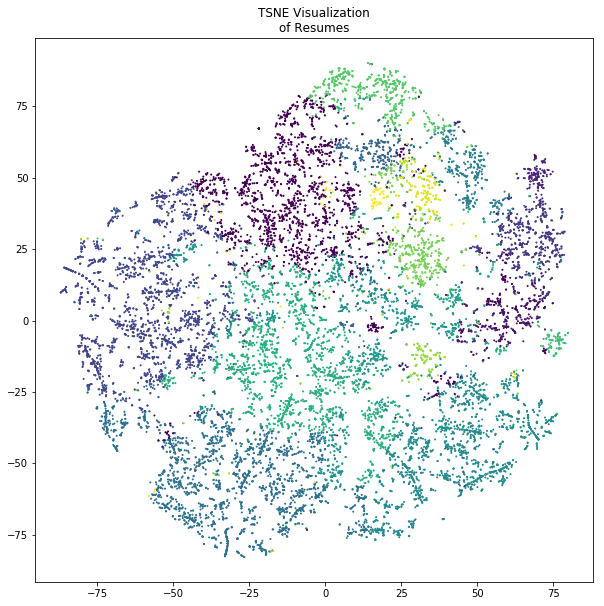

In [19]:
plt.figure(figsize = (10, 10))
plt.scatter(tsne_feature[:,0], tsne_feature[:,1], 
            s = 1, c = df['topic'])
plt.title("TSNE Visualization\nof Resumes")
plt.show()

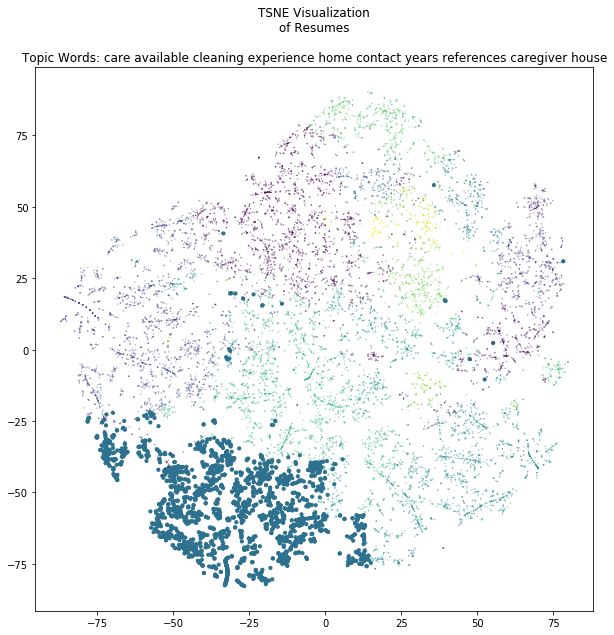

In [20]:
highlight_topic = 7
sizes = [10 if a == highlight_topic else 0.05 for a in df['topic']]
plt.figure(figsize = (10, 10))
plt.scatter(tsne_feature[:,0], tsne_feature[:,1], 
            s = sizes, c = df['topic'])
plt.title(f"TSNE Visualization\nof Resumes\n\nTopic Words: {topic_keyword_dict[highlight_topic]}")
plt.show()